In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
from sklearn.model_selection import train_test_split
import torch
import torchvision
from torchvision import transforms, utils
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms.v2 as transforms
from collections import Counter
from PIL import Image
from skimage import io, transform
import os
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader
from collections import Counter
import math
from torchvision import datasets
from torch.utils.data import Subset




In [21]:
torch.manual_seed(42)  
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(torch.__version__)
print(device)

2.6.0
cpu


## Data Preprocessing

In [22]:
# Defining transfomer
transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.RandomRotation(45),
    transforms.RandomPerspective(0.3, 0.5),
    transforms.Normalize(mean =[0.1307], std=[0.3081])
])

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [23]:
# Initiate the Dataset object for the training set as train_dataset
train_dataset = datasets.MNIST(
    root = "./data",
    train = True,
    download = True,
    transform = transform
)

all_indicies_train = len(train_dataset)
important_indices_train = list(range(0, all_indicies_train, 2))

#Downsam ple training by getting the train data at even-numbered indices, specified as train_subset
train_subset = Subset(train_dataset, important_indices_train)

# Initiate the dataset object for the test set as test_dataset
test_dataset = datasets.MNIST(
    root = "./data",
    train = False,
    download = True,
    transform = transform
)

all_indicies_test = len(test_dataset)
important_indices_test = list(range(0, all_indicies_test, 2))

# Downsample test by getting the test data at even-numbered indices, specified as test_subset
test_subset = Subset(test_dataset, important_indices_test)

In [24]:
batch = 64


# Initiate the DataLoader object for the training set as train_loader
train_loader = DataLoader(train_subset, batch_size=batch, shuffle=True, num_workers=0)

# Initiate the DataLoader object for the test set as test_loader
test_loader = DataLoader(test_subset, batch_size=batch, shuffle=True, num_workers=0)


## Data Summary and Visualization

In [25]:
train_num_labels = len(Counter([label for _, label in train_subset]))
test_num_labels = len(Counter([label for _, label in test_subset]))

train_loader_bar_plot = DataLoader(train_subset, batch_size=len(train_subset), shuffle = True, num_workers=0)
test_loader_bar_plot = DataLoader(test_subset, batch_size=len(test_subset), shuffle = True, num_workers=0)

train_subset_dict = Counter([label for _, label in train_subset])
test_subset_dict = Counter([label for _, label in test_subset])


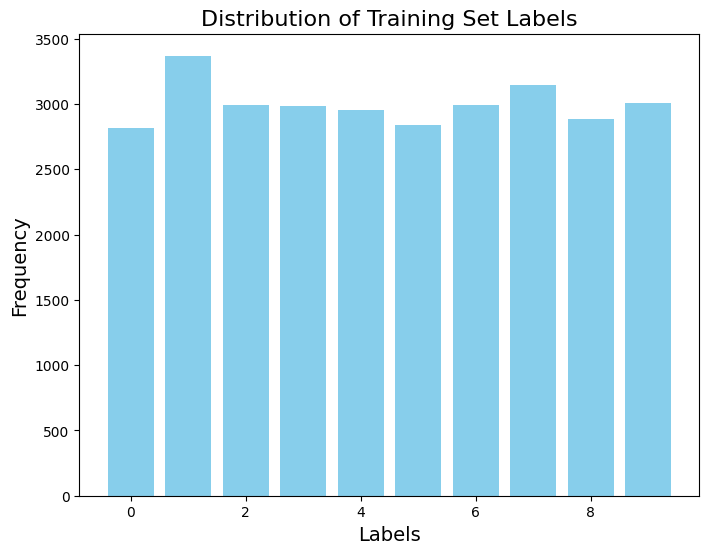

In [26]:
# Train Subset Bar Plot

x = [label for label, frequecy in train_subset_dict.items()]
y = [frequency for label, frequency in train_subset_dict.items()]

plt.figure(figsize=(8, 6))

plt.bar(x, y, color = "skyblue")

plt.title('Distribution of Training Set Labels', fontsize=16)  # Title of the plot
plt.xlabel('Labels', fontsize=14)  # X-axis label
plt.ylabel('Frequency', fontsize=14)  # Y-axis label

plt.show()


In [27]:
plt.close()

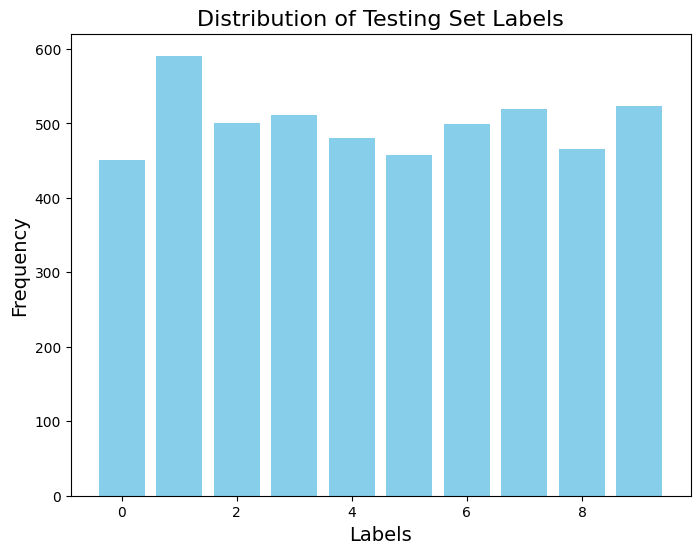

In [28]:
# Test Subset Bar Plot

x = [label for label, frequecy in test_subset_dict.items()]
y = [frequency for label, frequency in test_subset_dict.items()]

plt.figure(figsize=(8, 6))

plt.bar(x, y, color = "skyblue")

plt.title('Distribution of Testing Set Labels', fontsize=16)  # Title of the plot
plt.xlabel('Labels', fontsize=14)  # X-axis label
plt.ylabel('Frequency', fontsize=14)  # Y-axis label

plt.show()

In [29]:
plt.close()

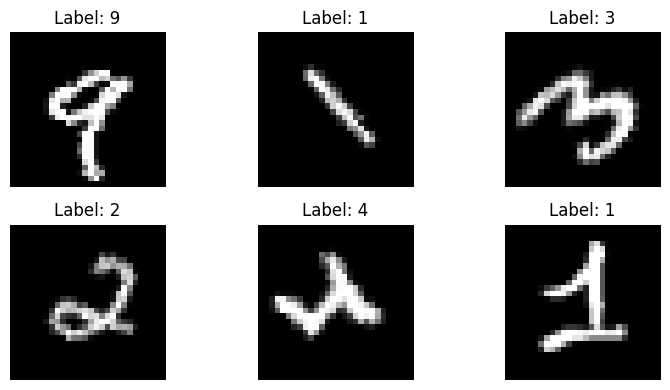

In [30]:
# Visualize 6 arbitrary images from the train_subset dataset

arbitrary_indices = [2, 4, 6, 8, 10, 12]

figs, ax = plt.subplots(2, 3, figsize=(8, 4))

flat_axes = ax.flatten()

for i, index in enumerate(arbitrary_indices):
  image, label = train_subset[index]

  image = image.squeeze().numpy()

  flat_axes[i].imshow(image, cmap='gray')
  flat_axes[i].set_title(f"Label: {label}")
  flat_axes[i].axis('off')

plt.tight_layout()

In [31]:
plt.close()

## Attempt 1: Logistic Regression Model

In [32]:
class LogisticRegressionModel(nn.Module):
    def __init__(self):
        # initialize the neural network layers (flatten, and then sequential with a Linear Layer(28 * 28, 10), and a sigmoid activation)
        super(LogisticRegressionModel, self).__init__()

        self.model = nn.Sequential(
            nn.Flatten(), # Flatten layer to transform input tensors into flat vectors
            nn.Linear(28 * 28, 10), # Linear layer with inputs from the flattened vector and outputs to 10 classes
            nn.Sigmoid() # Sigmoid activation function applied to the linear layer's output
        )


    def forward(self, x):
        outputs = self.model(x)
        return outputs

In [33]:
# Instantiate the model
logreg = LogisticRegressionModel().to(device)

# Set the loss criterion to be Cross Entropy Loss
criterion = nn.CrossEntropyLoss()

# Set the optimizer to be Adam with a learning rate of 1e-4
optimizer = optim.Adam(logreg.parameters(),lr = 1e-4)


epoch = 10

loss_LIST_log = []
acc_LIST_log = []

# Train the Model
for current_epoch in range(epoch):
  running_loss = 0.0
  correct = 0
  total = 0
  for inputs, labels in train_loader:
      labels = labels.type(torch.LongTensor) # Cast to Float
      inputs, labels = inputs.to(device), labels.to(device)

      
      # Reset the optimizer tensor gradient every mini-batch
      optimizer.zero_grad()


      # Feed the network the train data
      outputs = logreg(inputs)


      # Get the prediction using argmax
      _, predicted = torch.max(outputs.data, 1)


      #  Find average loss for one mini-batch of inputs
      loss = criterion(outputs, labels)

      #  Do a back propagation
      loss.backward()

      # Update the weight using the gradients from back propagation by learning step
      optimizer.step()

      # Get loss and add to accumulated loss for each epoch
      running_loss += loss.item() * inputs.size(0)

      # Get number of correct prediction and increment the number of correct and total predictions after this batch
      total += labels.size(0)
      correct += (predicted == labels).sum().item()


  # Calculate training accuracy for each epoch (should multiply by 100 to get percentage), store in variable called 'accuracy', and add to acc_LIST_log
  accuracy = 100 * correct / total
  acc_LIST_log.append(float(accuracy))


  # Get average loss for each epoch and add to loss_LIST_log
  epoch_loss = running_loss / total
  loss_LIST_log.append(float(epoch_loss))

  # Print the loss and accuracy for each epoch
  print(f'Epoch [{current_epoch + 1}/{epoch}], Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.2f}%')


Epoch [1/10], Loss: 2.1088, Accuracy: 43.27%
Epoch [2/10], Loss: 1.9498, Accuracy: 58.10%
Epoch [3/10], Loss: 1.8940, Accuracy: 61.10%
Epoch [4/10], Loss: 1.8687, Accuracy: 61.65%
Epoch [5/10], Loss: 1.8474, Accuracy: 62.68%
Epoch [6/10], Loss: 1.8363, Accuracy: 62.63%
Epoch [7/10], Loss: 1.8273, Accuracy: 63.01%
Epoch [8/10], Loss: 1.8221, Accuracy: 63.15%
Epoch [9/10], Loss: 1.8157, Accuracy: 63.53%
Epoch [10/10], Loss: 1.8097, Accuracy: 63.99%


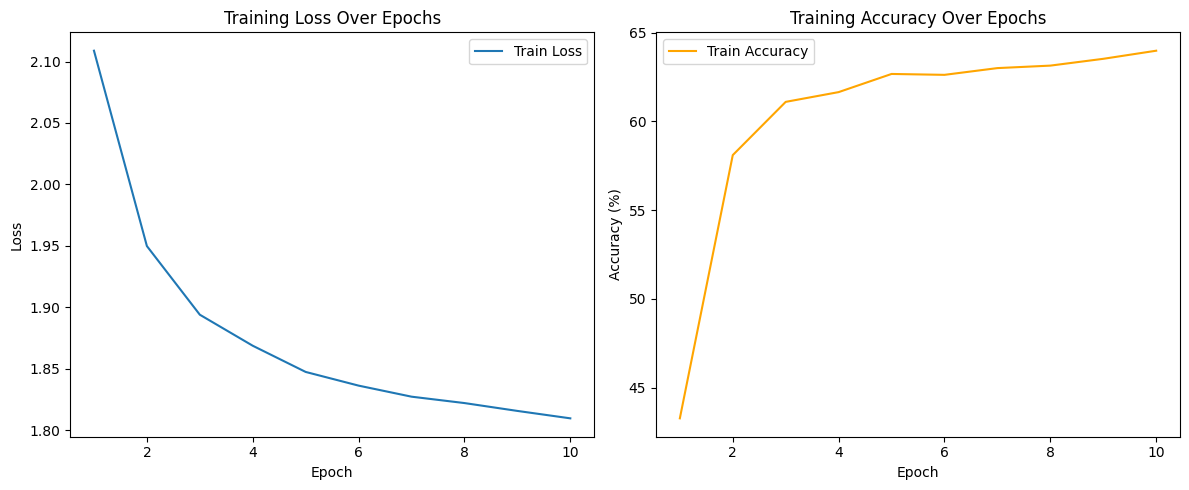

In [34]:
plt.figure(figsize=(12, 5))

# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(range(1, epoch+1), loss_LIST_log, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()

# Plot training accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, epoch+1), acc_LIST_log, label='Train Accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training Accuracy Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

In [35]:
plt.close()

In [36]:
# Run the trained logistic regression model on the test set and report the accuracy.

total = 0
correct = 0
with torch.no_grad():
    for images, labels in test_loader:
        labels = labels.type(torch.LongTensor)
        images, labels = images.to(device), labels.to(device)
        # Get the outputs by passing the test data through the model
        outputs = logreg(images)

        # Get the prediction using argmax
        _, predicted = torch.max(outputs.data, 1)

        # Get number of correct prediction and add to correct and total
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

# Calculate test accuracy for logistic regression (should multiply by 100)
test_acc_log = 100 * correct / total

# Print the test accuracy
print(f'Test Accuracy of the model on the test images: {test_acc_log:.2f}%')

Test Accuracy of the model on the test images: 64.72%


## Attempt 2: FNN

In [37]:
class FNN(nn.Module):
    def __init__(self):
        super().__init__()
        # initialize the neural network layers
        self.flatten = nn.Flatten()  # Flatten layer to convert 2D images to 1D vectors
        self.hidden_layer = nn.Linear(28*28, 256)  # First and only hidden layer with 256 neurons
        self.ReLU = nn.ReLU()  # Activation function for hidden layer
        self.output_layer = nn.Linear(256, 10)  # Output layer with 10 units for 10 classes


    def forward(self, x):
        # define the forward pass and return outputs
        x = self.flatten(x)  # Flatten the input
        x = self.hidden_layer(x)  # Pass through the hidden layer
        x = self.ReLU(x)  # Apply ReLU activation function
        outputs = self.output_layer(x)

        return outputs

In [38]:
# Sending the data to device (CPU or GPU)
fnn = FNN().to(device)

# Set the loss criterion as CrossEntropyLoss
criterion = nn.CrossEntropyLoss()

# Set the optimizer as Adam with a learning rate of 1e-4
optimizer = optim.Adam(fnn.parameters(), lr = 1e-4)

epoch = 10

acc_LIST_FNN = []
loss_LIST_FNN = []

# Train the FNN
for current_epoch in range(epoch):
  running_loss = 0.0
  correct = 0
  total = 0
  for inputs, labels in train_loader:
      labels = labels.type(torch.LongTensor) # Cast to Long
      inputs, labels = inputs.to(device), labels.to(device)

      # Reset the optimizer tensor gradient every mini-batch
      optimizer.zero_grad()

      # Feed the network the train data
      outputs = fnn(inputs)


      # Get the prediction using argmax
      _, predicted = torch.max(outputs.data, 1)


      # Find average loss for one mini-batch of inputs
      loss = criterion(outputs, labels)


      # Do a back propagation
      loss.backward()

      # Update the weight using the gradients from back propagation by learning step
      optimizer.step()

      # Get loss and add to accumulated loss for each epoch
      running_loss += loss.item() * inputs.size(0)

      # Get number of correct prediction and increment the number of correct and total predictions after this batch
      total += labels.size(0)
      correct += (predicted == labels).sum().item()


  # Calculate training accuracy for each epoch (should multiply by 100 to get percentage), store in variable called 'accuracy', and add to acc_LIST_FNN
  accuracy = 100 * correct / total
  acc_LIST_FNN.append(float(accuracy))

  # Get average loss for each epoch and add to loss_LIST_FNN
  epoch_loss = running_loss / total
  loss_LIST_FNN.append(float(epoch_loss))

  # Print the loss and accuracy for each epoch
  print(f'Epoch [{current_epoch + 1}/{epoch}], Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.2f}%')


Epoch [1/10], Loss: 1.3176, Accuracy: 59.81%
Epoch [2/10], Loss: 0.9569, Accuracy: 70.20%
Epoch [3/10], Loss: 0.8292, Accuracy: 74.54%
Epoch [4/10], Loss: 0.7417, Accuracy: 77.17%
Epoch [5/10], Loss: 0.6673, Accuracy: 79.53%
Epoch [6/10], Loss: 0.6023, Accuracy: 81.77%
Epoch [7/10], Loss: 0.5646, Accuracy: 82.87%
Epoch [8/10], Loss: 0.5204, Accuracy: 84.30%
Epoch [9/10], Loss: 0.4892, Accuracy: 85.09%
Epoch [10/10], Loss: 0.4661, Accuracy: 85.94%


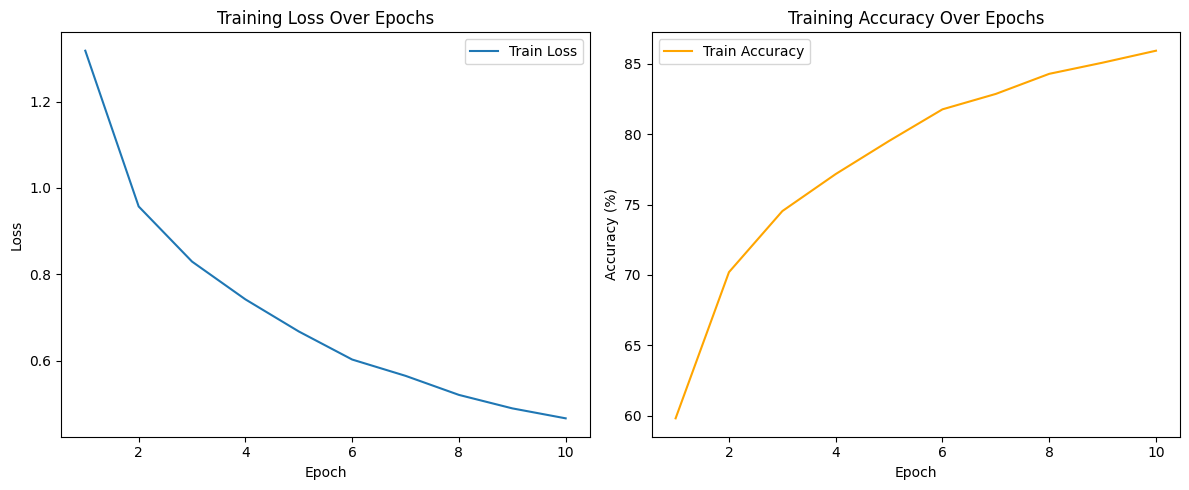

In [39]:
plt.figure(figsize=(12, 5))

num_epochs = 10

# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), loss_LIST_FNN, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()

# Plot training accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), acc_LIST_FNN, label='Train Accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training Accuracy Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()

In [40]:
plt.close()

In [41]:
# Running trained FNN model on test set

total = 0
correct = 0
with torch.no_grad():
    for images, labels in test_loader:
        labels = labels.type(torch.LongTensor)
        images, labels = images.to(device), labels.to(device)

        # Get the outputs by passing the test data through the model
        outputs = fnn(images)

        # Get the prediction using argmax
        _, predicted = torch.max(outputs.data, 1)

        # Get number of correct prediction and add to correct and total
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

# Calculate test accuracy for FNN (should multiply by 100)
test_acc_FNN = 100 * correct / total

# Print the test accuracy
print(f'Test Accuracy of the model on the test images: {test_acc_FNN:.2f}%')


Test Accuracy of the model on the test images: 86.54%
